In [1]:
import requests
import time
import pandas as pd
import ast # to transform str to dic
import praw #for reddit wrapper
import os

In [2]:
# Testing connection

url = 'https://www.reddit.com/hot.json'
header = {'User-agent': 'Bleep blorp bot 0.1'}
res = requests.get(url,headers=header)
the_json = res.json()
print(sorted(the_json.keys()))

the_json['data'].keys()
len(the_json['data']['children'])

['data', 'kind']


25

In [3]:
def get_posts(url,interations,header,sleep):
    posts = []
    after = None
    for i in range(interations):
#         print(i)
        if after==None:
            params = {}
        else:
            params = {'after' : after}
        res = requests.get(url,params=params,headers=header)
        if res.status_code == 200:
            the_json = res.json()
            posts.extend(the_json['data']['children'])
            after = the_json['data']['after']
        else:
            print(res.status_code)
            break
        time.sleep(sleep)
    return posts

def create_cols(dataframe):
    dataframe['subreddit'] = dataframe['data'].map(lambda x: x['subreddit'])
    dataframe['title'] = dataframe['data'].map(lambda x: x['title'])
    dataframe['name'] = dataframe['data'].map(lambda x: x['name'])
    dataframe['selftext'] = dataframe['data'].map(lambda x: x['selftext'])
    dataframe['domain'] = dataframe['data'].map(lambda x: x['domain'])
    return dataframe

In [4]:
# Setting up the Reddit API in python
reddit = praw.Reddit(client_id='mBPz4HF59_0MX5n7TXFGXg',
                     client_secret='L0YrbwjFpyLZs7ia5hTIUyEKuGVrvw',
                     user_agent='User')

# Function for extracting data
def get_posts(subred_name, n, time = 'all'):
    subreddit = reddit.subreddit(subred_name)
    posts_info = [] 
    
    for subm in subreddit.top(limit=n, time_filter=time):
        
        subred_info = []
        subred_info.append(subm.id)  
        subred_info.append(str(subm.author))
        subred_info.append(subm.title)
        subred_info.append(subm.selftext)
        subred_info.append(subm.score)  
        subred_info.append(subm.upvote_ratio)
        subred_info.append(subm.num_comments)
        subred_info.append(subm.subreddit)
        posts_info.append(subred_info)
    
    sorted_info = sorted(posts_info, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(sorted_info, columns = ['id','author', 'title', 'text', 'score','upvote_ratio' ,'num_comments', 'subreddit'])
    return posts_df

In [5]:
rant_df = get_posts('rant',1000,time="all")
OMC_df = get_posts('offmychest',1000,time="all")
TOMC_df = get_posts('trueoffmychest',1000,time="all")
self_df = get_posts('self',1000,time="all")

In [6]:
OMC_df['subreddit'] = "offmychest"
TOMC_df['subreddit'] = 'TrueOffMyChest'
rant_df['subreddit'] = 'rant'
self_df['subreddit'] = 'self'

full_df = pd.concat([OMC_df, TOMC_df, rant_df, self_df])

In [7]:
full_df

,id,author,title,text,score,upvote_ratio,num_comments,subreddit
0,i1szdi,zoyaa5,The abuse of essential workers needs to stop.,I have dealt with a lot of insanity since this...,8130,0.97,295,offmychest
1,tnk97h,yrthegood1staken,I Miss Her,"My alarm went off at 5:15 this morning, like i...",7522,0.92,575,offmychest
2,x4aag7,yourwrongdoings,My roommate killed my kitten.,Last night my roommate got mad at my kitten af...,6893,0.98,746,offmychest
3,hv24zz,yourmomisexpwaste,Wearing a mask has nothing to do with politics...,Body text\n\n\nAn edit for people who have bee...,24863,0.92,864,offmychest
4,gmlmtr,youngffinance,"I am usually pretty Libertarian, but after thi...",My husband recently broke a bone and had to ha...,9264,0.94,777,offmychest
...,...,...,...,...,...,...,...,...
985,4twyxv,1millionbucks,HEY ADMINS: /r/redditrequest now has a 34 day ...,"Welcome to the modern age, where you have to m...",1618,0.90,109,self
986,230ohk,15963256,A professor just emailed me and now I'm crying,I have the same instructor for 3 classes this ...,1163,0.92,78,self
987,82ax16,1369311007,Resigning my NRA membership.,I will miss the history of firearms in the mag...,956,0.83,180,self
988,vb3oj3,12jonboy12,what I say to my 21-year-old cat every night b...,"I bring him to bed with me and I say:\n ""I'd r...",2245,0.98,182,self


In [8]:
# Load the regular expression library
import re
def cleanUp(df, columnTo, columnFrom):
    # Remove punctuation
    df[columnTo] = df[columnFrom].map(lambda x: re.sub('[,\.!?]', '', x))
    # Convert the titles to lowercase
    df[columnTo] = df[columnFrom].map(lambda x: x.lower())
    return df

In [9]:
rant_df = cleanUp(rant_df, 'textClean', 'text')
OMC_df = cleanUp(OMC_df, 'textClean', 'text')
TOMC_df = cleanUp(TOMC_df, 'textClean', 'text')
self_df = cleanUp(self_df, 'textClean', 'text')
full_df = cleanUp(full_df, 'textClean', 'text')

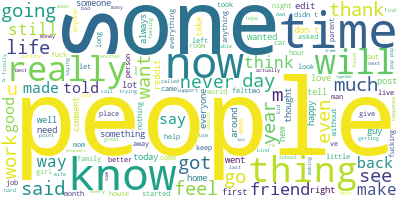

In [10]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(self_df['textClean'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [11]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = full_df.textClean.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacobelder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['dealt', 'lot', 'insanity', 'since', 'pandemic', 'started', 'think', 'yesterday', 'took', 'cake', 'year', 'old', 'female', 'work', 'grocery', 'store', 'yesterday', 'man', 'refused', 'wear', 'mask', 'asthma', 'told', 'would', 'ring', 'groceries', 'put', 'without', 'raising', 'voice']


In [12]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [13]:
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"know" + 0.007*"people" + 0.006*"get" + 0.006*"one" + 0.006*"like" + '
  '0.005*"time" + 0.005*"would" + 0.005*"got" + 0.005*"life" + 0.004*"much"'),
 (1,
  '0.010*"like" + 0.008*"people" + 0.006*"fucking" + 0.005*"get" + '
  '0.005*"know" + 0.005*"one" + 0.005*"want" + 0.005*"life" + 0.004*"would" + '
  '0.004*"got"'),
 (2,
  '0.011*"people" + 0.010*"like" + 0.006*"get" + 0.006*"one" + 0.006*"time" + '
  '0.006*"would" + 0.006*"even" + 0.006*"know" + 0.005*"want" + 0.004*"much"'),
 (3,
  '0.064*"fuck" + 0.010*"like" + 0.007*"people" + 0.006*"get" + 0.006*"would" '
  '+ 0.005*"time" + 0.005*"even" + 0.004*"going" + 0.004*"really" + '
  '0.004*"one"'),
 (4,
  '0.007*"like" + 0.007*"know" + 0.007*"get" + 0.006*"people" + 0.006*"one" + '
  '0.005*"time" + 0.005*"never" + 0.004*"want" + 0.004*"even" + '
  '0.004*"really"')]


In [14]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/jacobelder/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/jacobelder/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jacobelder/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jacobelder/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jacobelder/opt/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.005432  0.002139       1        1  42.699146
0     -0.006436  0.001896       2        1  20.110446
4     -0.007123  0.006402       3        1  18.351191
3      0.025485  0.000051       4        1   9.814638
1     -0.006494 -0.010488       5        1   9.024580, topic_info=        Term         Freq        Total Category  logprob  loglift
18      fuck  3857.000000  3857.000000  Default  30.0000  30.0000
157     like  3942.000000  3942.000000  Default  29.0000  29.0000
316   people  3994.000000  3994.000000  Default  28.0000  28.0000
19       get  2907.000000  2907.000000  Default  27.0000  27.0000
496  fucking  1619.000000  1619.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
597     said   127.342258  1641.109982   Topic5  -5.7769  -0.1510
953    thank   110.875668  1269.750966   Topic5  -5.9154  -0.0329
251    could   113.618919  1347.453910   Topic5  -5.8910  -0.0679
473     even   128.761632  2175.876026   Topic5  -5.7658  -0.4220
245    years   112.325350  1700.040453   Topic5  -5.9024  -0.3118

[460 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
19133      3  0.735502  adblocker
290        1  0.282692     adhere
290        3  0.565384     adhere
2023       1  0.188545        ads
2023       2  0.487074        ads
...      ...       ...        ...
10201      1  0.164018  youtubers
10201      2  0.492054  youtubers
10201      3  0.164018  youtubers
10187      2  0.510811        yro
6943       1  0.811219    zzftqxp

[939 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 4, 2])

In [15]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = full_df.textClean.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['have', 'dealt', 'with', 'lot', 'of', 'insanity', 'since', 'this', 'pandemic', 'started', 'but', 'think', 'yesterday', 'took', 'the', 'cake', 'year', 'old', 'female', 'work', 'at', 'grocery', 'store', 'yesterday', 'man', 'refused', 'to', 'wear', 'mask', 'because']


In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['deal', 'lot', 'insanity', 'pandemic', 'start', 'think', 'yesterday', 'take', 'cake', 'female', 'work', 'yesterday', 'man', 'refuse', 'asthma', 'tell', 'ring', 'grocery', 'put', 'raise', 'voice', 'telling', 'already', 'call', 'lawyer', 'sue', 'closing', 'time', 'woman', 'neck', 'ask', 'nicely', 'seriously', 'pull', 'come', 'line', 'nod', 'pull', 'get', 'drive', 'parking_lot', 'scream', 'fuck', 'pull', 'next', 'red', 'light', 'scream', 'highly', 'regret', 'take', 'video', 'really', 'thing', 'interaction', 'bothering', 'get', 'face', 'video', 'try', 'job', 'bring', 'virus', 'home', 'try', 'ring', 'grocery', 'protect', 'family', 'believe', 'virus', 'see', 'much', 'ugly', 'dishearten']]


In [19]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 3), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 1), (58, 2), (59, 2), (60, 1), (61, 1), (62, 1), (63, 2)]]


In [20]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=100,
                                       per_word_topics=True)

In [21]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"thank" + 0.017*"feel" + 0.015*"edit" + 0.014*"make" + 0.014*"much" + '
  '0.013*"love" + 0.013*"get" + 0.013*"want" + 0.012*"people" + '
  '0.012*"really"'),
 (1,
  '0.011*"supporter" + 0.007*"stream" + 0.006*"fish" + 0.005*"template" + '
  '0.005*"discount" + 0.004*"ed" + 0.004*"batshit" + 0.003*"baggage" + '
  '0.003*"viewer" + 0.003*"whale"'),
 (2,
  '0.021*"fuck" + 0.018*"get" + 0.017*"work" + 0.013*"go" + 0.011*"make" + '
  '0.011*"job" + 0.010*"people" + 0.009*"pay" + 0.009*"time" + 0.008*"money"'),
 (3,
  '0.039*"dog" + 0.024*"cat" + 0.009*"neighbor" + 0.008*"water" + 0.008*"pet" '
  '+ 0.008*"put" + 0.006*"walk" + 0.006*"owner" + 0.005*"hand" + '
  '0.005*"fence"'),
 (4,
  '0.019*"die" + 0.019*"doctor" + 0.019*"nurse" + 0.017*"care" + '
  '0.016*"hospital" + 0.015*"covid" + 0.011*"people" + 0.011*"patient" + '
  '0.010*"sick" + 0.008*"mask"'),
 (5,
  '0.022*"go" + 0.020*"get" + 0.016*"tell" + 0.013*"say" + 0.013*"know" + '
  '0.012*"time" + 0.009*"want" + 0.009*"

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=100,
                                           alpha=0.61,
                                           eta=0.91)

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared